## Problem

### High-level problem statement

E-commerce websites often transact huge amounts of money. Whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, laundering money, etc. 

### Objective
The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

### Details
Electronica is an e-commerce site that sells wholesale electronics. You have been contracted to build a model that predicts whether a given transaction is fraudulent or not. You only have information about each user’s first transaction on Electronica’s website. If you fail to identify a fraudulent transaction, Electronica loses money equivalent to the price of the fraudulently purchased product. If you incorrectly flag a real transaction as fraudulent, it inconveniences the Electronica customers whose valid transactions are flagged—a cost your client values at $8.



## Solution

### data exploration

In [1]:
# load the the two datasets provided

In [2]:
import pandas as pd

df1 = pd.read_csv("../rawdata/Candidate_tech_evaluation_candidate_copy_data science_fraud.csv", index_col=0)

In [3]:
df2 = pd.read_excel("../rawdata/Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx")

In [4]:
# Explore dataset 1

print(df1.head())
print(df1.info())

        user_id      signup_time    purchase_time  purchase_value  \
149671   285108   7/15/2015 4:36  9/10/2015 14:17              31   
15611    131009  1/24/2015 12:29   4/13/2015 4:53              31   
73178    328855   3/11/2015 0:54   4/5/2015 12:23              16   
84546    229053   1/7/2015 13:19   1/9/2015 10:12              29   
35978    108439   2/8/2015 21:11   4/9/2015 14:26              26   

            device_id  source  browser sex  age    ip_address  class  
149671  HZAKVUFTDOSFD  Direct   Chrome   M   49  2.818400e+09      0  
15611   XGQAJSOUJIZCC     SEO       IE   F   21  3.251268e+09      0  
73178   VCCTAYDCWKZIY  Direct       IE   M   26  2.727760e+09      0  
84546   MFFIHYNXCJLEY     SEO   Chrome   M   34  2.083420e+09      0  
35978   WMSXWGVPNIFBM     Ads  FireFox   M   33  3.207913e+09      0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 149671 to 46646
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 

In [5]:
#Distribution of the label column
dist = df1['class'].value_counts()
print(dist)
print('The normal class is',round(dist[0]/dist[1],1),'times more than the fraud class')
#there is imbalance

0    108735
1     11265
Name: class, dtype: int64
The normal class is 9.7 times more than the fraud class


In [6]:
df1.shape

(120000, 11)

In [7]:
# Explore dataset 2

print(df2.head())
print(df2.info())

   lower_bound_ip_address  upper_bound_ip_address    country
0                16777216                16777471  Australia
1                16777472                16777727      China
2                16777728                16778239      China
3                16778240                16779263  Australia
4                16779264                16781311      China
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   lower_bound_ip_address  138846 non-null  int64 
 1   upper_bound_ip_address  138846 non-null  int64 
 2   country                 138846 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB
None


In [8]:
df2.shape

(138846, 3)

In [9]:
# check missing values in dataset 1
df1.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [10]:
# check missing values in dataset 2
df2.isnull().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [11]:
# Check duplicates
print(df1["user_id"].nunique())
print(len(df1.user_id))

120000
120000


### data transformation

In [12]:
# Convert columns signup_time and purchase_time to datetime format

df1['signup_time'] = pd.to_datetime(df1['signup_time'], format='%m/%d/%Y %H:%M')
df1['purchase_time'] = pd.to_datetime(df1['purchase_time'], format='%m/%d/%Y %H:%M')

In [13]:
# create a function which maps the country from dataset 2 to dataset 1 given the ip addresses

# Function to check IP address against lower and upper bounds
def get_country(ip):
    country = df2[(df2['lower_bound_ip_address'] <= ip) & (df2['upper_bound_ip_address'] >= ip)]['country']
    return country.values[0] if not country.empty else None

In [14]:
# Apply the function to the ip_address column in df1

df1['country'] = df1['ip_address'].apply(get_country)

In [15]:
# check missing values in dataset 1 after adding country
df1.isnull().sum()

user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
country           17418
dtype: int64

In [16]:
# Replace null values in the 'country' column with 'unknown'
df1['country'].fillna('unknown', inplace=True)
# check for null values again
df1.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

### continue data exploration with some graphs

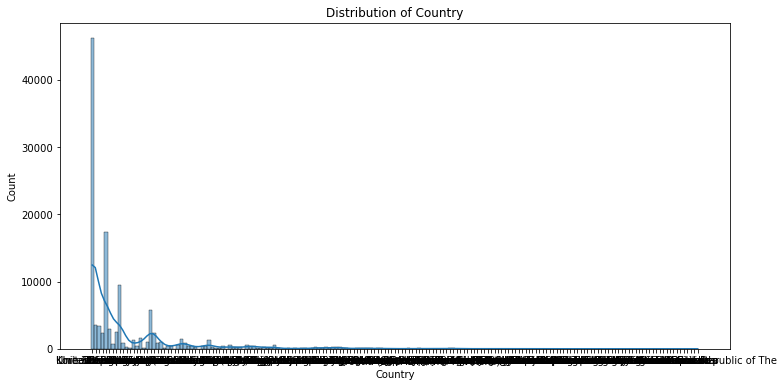

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Explore the distribution of country
plt.figure(figsize=(12, 6))
sns.histplot(df1['country'], bins=30, kde=True)
plt.title('Distribution of Country')
plt.xlabel('Country')
plt.show()

<Figure size 432x288 with 0 Axes>

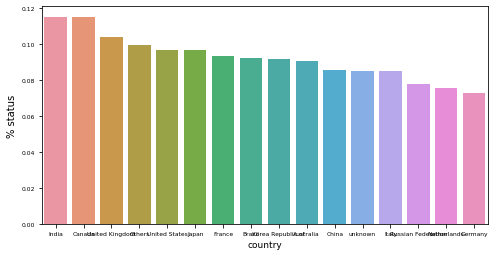

In [18]:
# calculate country frequency and encode the country if it has less than 1000 consumers as 'Others'
df1['n_country_shared'] = df1.country.map(df1.country.value_counts(dropna=False))
threshold = 1000
index = df1['n_country_shared']<threshold
df1.loc[index,['country']]='Others'

#sort fraud rates
plt.figure()
sns.set_palette("Blues_r")
fig, ax = plt.subplots(figsize=(8,4))

# Calculate the percentage of target=1 per country
cat_perc = df1[['country', 'class']].groupby(['country'],as_index=False).mean()
cat_perc.sort_values(by='class',ascending=False,inplace=True)

# Bar plot
# Order the bars descending on target mean
    
sns.barplot(ax=ax, x='country', y='class', data=cat_perc, order=cat_perc['country'])

plt.ylabel('% status', fontsize=10)
plt.xlabel('country', fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.show();

In [19]:
#country - create risk profile for each country
fraud_rate_country = df1.groupby('country')['class'].value_counts(normalize=True).loc[:,1].sort_values(ascending=False)
def state_risk_classifier(v):
    global highrisk_country, mediumrisk_country, lowrisk_country
    highrisk_country=[]
    mediumrisk_country=[]
    lowrisk_country=[]
    
    for country in v.index:
        if v[country]>=0.1:
            highrisk_country.append(country)
        elif v[country]<0.08:
            lowrisk_country.append(country)
        else:
            mediumrisk_country.append(country)
    
    print('countries with high risk:', highrisk_country)
    print('countries with medium risk:', mediumrisk_country)
    print('countries with low risk:',lowrisk_country)

state_risk_classifier(fraud_rate_country)

countries with high risk: ['India', 'Canada', 'United Kingdom']
countries with medium risk: ['Others', 'United States', 'Japan', 'France', 'Brazil', 'Korea Republic of', 'Australia', 'China', 'unknown', 'Italy']
countries with low risk: ['Russian Federation', 'Netherlands', 'Germany']


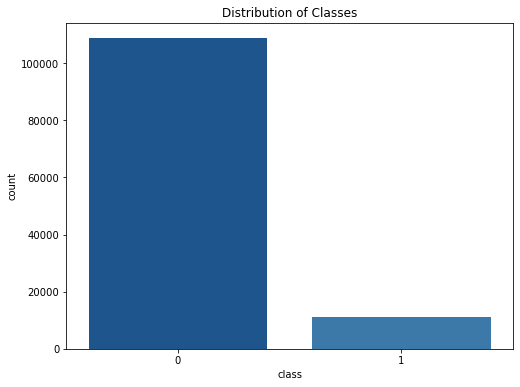

In [20]:
# Explore the distribution of the target variable (class)
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df1)
plt.title('Distribution of Classes')
plt.show()

As expected in fraud detection, there is a class imbalance (very few fraudulent cases). In this case, it’s very easy to get a high accuracy even with a simple linear learner. However, despite the high accuracy, there are still several false positives and false negatives. This is not surprising because even a rule-based system (e.g. simple if-else statement) that labels everything as negative (not fraudulent) would still achieve a high accuracy with highly imbalanced data.

To overcome this issue, our model needs to be tuned such that it’s optimized for either precision or recall. Since we want to
catch as many fradulent transactions as possible then optimize we will optimize our model for high recall

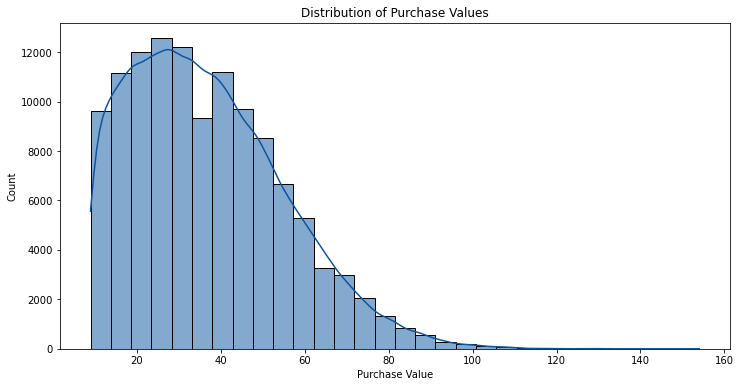

In [21]:
# Explore the distribution of purchase values
plt.figure(figsize=(12, 6))
sns.histplot(df1['purchase_value'], bins=30, kde=True)
plt.title('Distribution of Purchase Values')
plt.xlabel('Purchase Value')
plt.show()

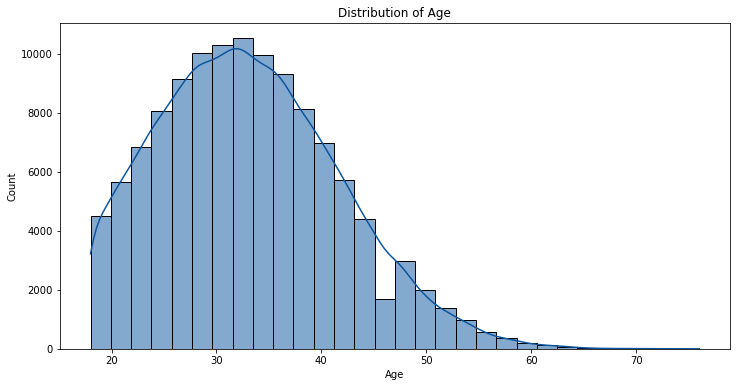

In [22]:
# Explore the distribution of age
plt.figure(figsize=(12, 6))
sns.histplot(df1['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()

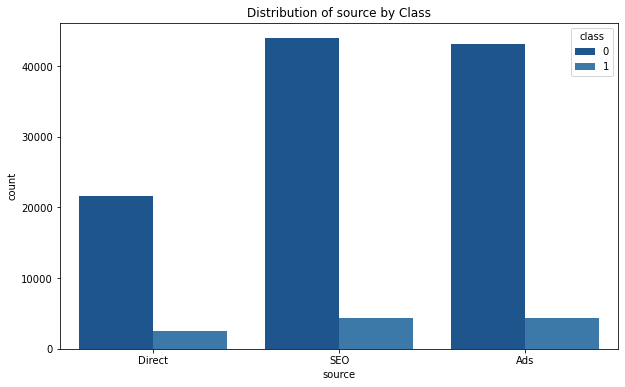

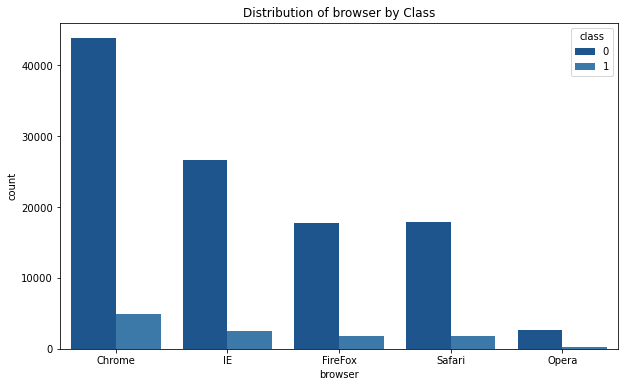

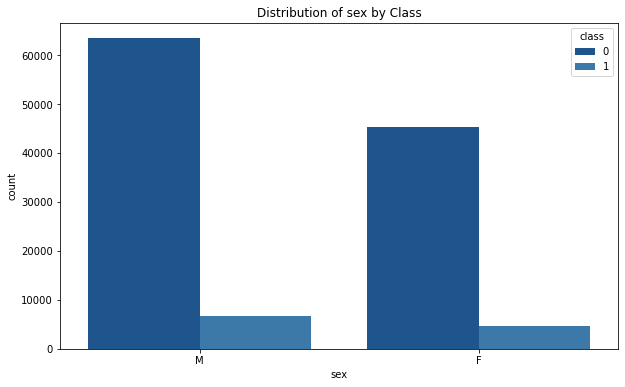

In [23]:
# Explore the distribution of categorical features
categorical_features = ['source', 'browser', 'sex']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='class', data=df1)
    plt.title(f'Distribution of {feature} by Class')
    plt.show()

## feature engineering

In [24]:
#Calculate the time difference between signup and purchase
df1['time_diff'] = (df1['purchase_time'] - df1['signup_time']).dt.total_seconds()

In [25]:
#calculate the frequency of each device_id to identify patterns related to specific devices
df1['device_frequency'] = df1.groupby('device_id')['device_id'].transform('count')

In [26]:
# calculate the day and the hour of the day from the purchase_time
df1['purchase_day_of_week'] = df1['purchase_time'].dt.dayofweek
df1['purchase_hour_of_day'] = df1['purchase_time'].dt.hour

In [27]:
# create feature interaction between purchase_value and age
df1['purchase_value_times_age'] = df1['purchase_value'] * df1['age']

In [28]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,n_country_shared,time_diff,device_frequency,purchase_day_of_week,purchase_hour_of_day,purchase_value_times_age
149671,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,46184,4959660.0,2,3,14,1519
15611,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,3580,6798240.0,1,0,4,651
73178,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,46184,2201340.0,1,6,12,416
84546,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,3341,161580.0,1,4,10,986
35978,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,2353,5159700.0,1,3,14,858


## Data Split

In [29]:
from sklearn.model_selection import train_test_split

y = df1['class']
X = df1.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class'], axis=1)  # drop irrelevant columns 

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (96000, 12)
y_train.shape: (96000,)
X_test.shape: (24000, 12)
y_test.shape: (24000,)


In [30]:
X_train.head()

,purchase_value,source,browser,sex,age,country,n_country_shared,time_diff,device_frequency,purchase_day_of_week,purchase_hour_of_day,purchase_value_times_age
5880,59,SEO,Safari,M,30,United States,46184,8342700.0,1,6,19,1770
129242,61,SEO,Safari,M,23,United States,46184,0.0,11,6,14,1403
50070,53,Ads,Safari,M,37,United States,46184,8145720.0,1,2,12,1961
62015,45,SEO,Chrome,M,32,Others,967,5334780.0,1,3,9,1440
17415,44,Ads,Chrome,M,40,United States,46184,2392680.0,1,0,8,1760


In [31]:
### Convert categorical features with less than 4 classes using one-hot encoding
#One hot encoding for source and browser features

#Training set
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])
X_train['sex'] = (X_train.sex == 'M').astype(int)

#Testing set
X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

In [32]:
#create bins for country
def country_conversion(s):
    if s in highrisk_country:
        return 'high risk'
    elif s in mediumrisk_country:
        return 'medium risk'
    else:
        return 'low risk'


X_train['country'] = X_train['country'].apply(country_conversion)
X_train['country'].value_counts()


medium risk    86101
high risk       5505
low risk        4394
Name: country, dtype: int64

In [33]:
X_test['country'] = X_test['country'].apply(country_conversion)
X_test['country'].value_counts()

medium risk    21465
high risk       1433
low risk        1102
Name: country, dtype: int64

In [34]:
X_train = pd.get_dummies(X_train, columns=['country'])
X_test = pd.get_dummies(X_test, columns=['country'])

In [35]:
X_train.head()

,purchase_value,sex,age,n_country_shared,time_diff,device_frequency,purchase_day_of_week,purchase_hour_of_day,purchase_value_times_age,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,country_high risk,country_low risk,country_medium risk
5880,59,1,30,46184,8342700.0,1,6,19,1770,0,0,1,0,0,0,0,1,0,0,1
129242,61,1,23,46184,0.0,11,6,14,1403,0,0,1,0,0,0,0,1,0,0,1
50070,53,1,37,46184,8145720.0,1,2,12,1961,1,0,0,0,0,0,0,1,0,0,1
62015,45,1,32,967,5334780.0,1,3,9,1440,0,0,1,1,0,0,0,0,0,0,1
17415,44,1,40,46184,2392680.0,1,0,8,1760,1,0,0,1,0,0,0,0,0,0,1


In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 24946 to 28230
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   purchase_value            24000 non-null  int64  
 1   sex                       24000 non-null  int32  
 2   age                       24000 non-null  int64  
 3   n_country_shared          24000 non-null  int64  
 4   time_diff                 24000 non-null  float64
 5   device_frequency          24000 non-null  int64  
 6   purchase_day_of_week      24000 non-null  int64  
 7   purchase_hour_of_day      24000 non-null  int64  
 8   purchase_value_times_age  24000 non-null  int64  
 9   source_Ads                24000 non-null  uint8  
 10  source_Direct             24000 non-null  uint8  
 11  source_SEO                24000 non-null  uint8  
 12  browser_Chrome            24000 non-null  uint8  
 13  browser_FireFox           24000 non-null  uint8  
 14  br

In [37]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#Normalization: (min-max) to [0,1]
#Using normalization since it would give us the positive columns

#Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(X_train[['device_frequency','n_country_shared','time_diff','purchase_value_times_age']]) 
#print(scaler.data_max_)

#transform the training data and use them for the model training
X_train[['device_frequency','n_country_shared','time_diff','purchase_value_times_age']] = scaler.transform(X_train[['device_frequency','n_country_shared','time_diff','purchase_value_times_age']])

#before the prediction of the test data, apply the same scaler obtained from above on X_test, not fitting a brandnew scaler on test
X_test[['device_frequency','n_country_shared','time_diff','purchase_value_times_age']] = scaler.transform(X_test[['device_frequency','n_country_shared','time_diff','purchase_value_times_age']])                                                                                     

In [38]:
X_train.head()

,purchase_value,sex,age,n_country_shared,time_diff,device_frequency,purchase_day_of_week,purchase_hour_of_day,purchase_value_times_age,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,country_high risk,country_low risk,country_medium risk
5880,59,1,30,1.000000,0.804663,0.000000,6,19,0.256951,0,0,1,0,0,0,0,1,0,0,1
129242,61,1,23,1.000000,0.000000,0.555556,6,14,0.198306,0,0,1,0,0,0,0,1,0,0,1
50070,53,1,37,1.000000,0.785664,0.000000,2,12,0.287472,1,0,0,0,0,0,0,1,0,0,1
62015,45,1,32,0.020917,0.514546,0.000000,3,9,0.204219,0,0,1,1,0,0,0,0,0,0,1
17415,44,1,40,1.000000,0.230777,0.000000,0,8,0.255353,1,0,0,1,0,0,0,0,0,0,1


## Experiments

### Simple ML Model - baseline with random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, recall_score

# Define models
random_forest_model = RandomForestClassifier(random_state=42)

# Train and evaluate Random Forest model
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("\n")


Random Forest:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       0.99      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.97      0.77      0.83     24000
weighted avg       0.96      0.96      0.95     24000

[[21754    14]
 [ 1047  1185]]
Recall: 0.5309139784946236




### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression(random_state=42)

# Train and evaluate Logistic Regression model
logistic_regression_model.fit(X_train, y_train)
y_pred_lr = logistic_regression_model.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("\n")

Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     21768
           1       0.92      0.52      0.66      2232

    accuracy                           0.95     24000
   macro avg       0.94      0.76      0.82     24000
weighted avg       0.95      0.95      0.94     24000

Recall: 0.5152329749103942




C:\Users\AIoanni1\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Gradient Boosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

# Define models
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

# Train and evaluate Gradient Boosting model
gradient_boosting_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gradient_boosting_model.predict(X_test)

print("Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("\n")

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       1.00      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.98      0.76      0.83     24000
weighted avg       0.96      0.96      0.95     24000

Recall: 0.5291218637992832




### Parameter Tuning - optimize for F1 score

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, f1_score

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Hyperparameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Hyperparameter distributions for Gradient Boosting
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

In [43]:
# Perform Randomized Search for Random Forest
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf,
                                       scoring=scorer, cv=3, n_iter=5, random_state=42)
random_search_rf.fit(X_train, y_train)

# Get the best Random Forest model
best_rf_model = random_search_rf.best_estimator_

# Predict on the test set using the best Random Forest model
y_pred_rf_best = best_rf_model.predict(X_test)

print("Random Forest (Best Model):")
print(classification_report(y_test, y_pred_rf_best))
print("Recall:", recall_score(y_test, y_pred_rf_best))
print("\n")

Random Forest (Best Model):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       1.00      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.98      0.76      0.83     24000
weighted avg       0.96      0.96      0.95     24000

Recall: 0.5291218637992832




In [44]:
# Perform Randomized Search for Gradient Boosting
random_search_gb = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), param_distributions=param_dist_gb,
                                       scoring=scorer, cv=3, n_iter=5, random_state=42)
random_search_gb.fit(X_train, y_train)

# Get the best Gradient Boosting model
best_gb_model = random_search_gb.best_estimator_

# Predict on the test set using the best Gradient Boosting model
y_pred_gb_best = best_gb_model.predict(X_test)

print("Gradient Boosting (Best Model):")
print(classification_report(y_test, y_pred_gb_best))
print("Recall:", recall_score(y_test, y_pred_gb_best))
print("\n")

Gradient Boosting (Best Model):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21768
           1       1.00      0.53      0.69      2232

    accuracy                           0.96     24000
   macro avg       0.98      0.76      0.83     24000
weighted avg       0.96      0.96      0.95     24000

Recall: 0.5291218637992832




In [45]:
# trying resampling with random forest model to see if there is any benefit

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.model_selection import train_test_split

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score)

# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Train Random Forest on the resampled data
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest (with Oversampling):")
print(classification_report(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

Random Forest (with Oversampling):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21768
           1       0.93      0.55      0.69      2232

    accuracy                           0.95     24000
   macro avg       0.94      0.77      0.83     24000
weighted avg       0.95      0.95      0.95     24000

F1 Score: 0.6885245901639344


We can conclude that oversampling did not provide any huge benefit so we are not going to use it.

### Model selection

Based on the results above on the models' performance , it can be seen that there is no big difference between random forest and gradient boosting.
Considering Random forest is faster, I propose random forest as the best model for this project.


Text(0, 0.5, 'Feature Importance Score')

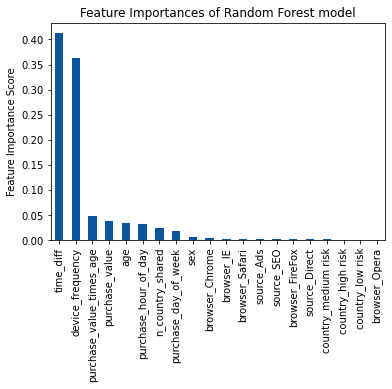

In [47]:
#features importance

predictors = [x for x in X_train.columns]
feat_imp = pd.Series(best_rf_model.feature_importances_,predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances of Random Forest model')
plt.ylabel('Feature Importance Score')

#### features importance 

time_diff and device frequency features dominate the predictive performance of our model.
